In [205]:
%matplotlib inline
import os 
import sys
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import statsmodels.formula.api as smf
import scipy.stats as ss 
import math 
from outliers import smirnov_grubbs as grubbs

plt.rcParams['font.family'] = 'Myriad Pro'
sns.set_style('white')

datadir       = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/JULY29'
savefigdir    = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python'


measures  = [#'R_Caud', 'R_Puta', 'R_Pall', 'R_Thal',   # 'R_Amyg', 'R_Hipp', 'R_Accu',
             'L_Caud', 'L_Puta', 'L_Pall',  'L_Thal',   # 'L_Amyg', 'L_Hipp', 'L_Accu',
             'L_BG', 'R_BG',
             #'R_RN', 'R_SN', 'R_STN', 
             'L_RN', 'L_SN', 'L_STN',
            ]

measures = ['Caud_Puta', 'Thal', 'SN', 'STN', 'RN','Pall', 'str_div3_motor', 'str_div3_limbic', 'str_div3_executive']
           
bigmasks = ['L_BrainStem','L_BasalGanglia', 'L_ALL_NUCLEI' ]


In [206]:
controls = pd.read_csv(os.path.join(datadir, 'controls_qc.csv'),index_col =0)
patients = pd.read_csv(os.path.join(datadir, 'patients_qc.csv'),index_col =0)

In [207]:
def cohen_d(df1,df2, metabolite):
    x = df1[metabolite].dropna(axis=0)
    y = df2[metabolite].dropna(axis=0)
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)

def grubbs_outliers(df, measure, alpha = 0.05):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 

def gESD_outliers(df, measure, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df[measure],maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

def calc_confidence_95(df1,df2, metabolite):
    import numpy as np, statsmodels.stats.api as sms
    X1 = df1[metabolite].dropna(axis=0)
    X2 = df2[metabolite].dropna(axis=0)
    cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
    return cm.tconfint_diff(usevar='pooled')

def make_statistical_comparison(df_controls, df_patients, stat, measures = measures, grubbs = False, ESD = False):
    df_controls['Group'] = 0
    df_patients['Group'] = 1
    cols = ['N','Controls', 'Patients','Levene','KS', 'KS_C', 'KS_P','D','CI_95', 'Statistic', 'p_val', 'p_fdr', 'sig']
    dfs = pd.DataFrame(index= cols, columns=measures)
    
    if grubbs:
        for measure in measures:
            grubbs_controls = grubbs_outliers(df_controls, measure)
            grubbs_patients = grubbs_outliers(df_patients, measure)
            print 'GRUBBS OUTLIERS=', measure, grubbs_controls, grubbs_patients
            for subject in grubbs_controls :
                df_controls.ix[subject,measure] = np.nan
            for subject in grubbs_patients :
                df_patients.ix[subject,measure] = np.nan
    elif ESD:
        for measure in measures:
            grubbs_controls = gESD_outliers(df_controls, measure)
            grubbs_patients = gESD_outliers(df_patients, measure)
            print 'gESD OUTLIERS=', measure, grubbs_controls, grubbs_patients
            for subject in grubbs_controls :
                df_controls.ix[subject,measure] = np.nan
            for subject in grubbs_patients :
                df_patients.ix[subject,measure] = np.nan
        
    df = pd.concat([df_controls, df_patients])
    for measure in measures:
        if stat == 'MR':
            formula = '%s ~ Group + Age + Gender + EFC_MAG + QI1_MAG + FBER_MAG + SNR_MAG'%measure
            model   = smf.ols(formula=formula, data = df)
            fit     = model.fit()
            p_val   = np.round(fit.pvalues[1],5)
            t_val   = np.round(fit.tvalues[1],3)
        
        elif stat == 'MW':
            
            t_val, p_val = mannwhitneyu(df_controls[measure].dropna(), df_patients[measure].dropna())
            
        elif stat == 'TT':
            t_val, p_val = ttest_ind(df_controls[measure].dropna(), df_patients[measure].dropna())
            
        ci95 = calc_confidence_95(df_controls, df_patients, measure)
        xval = 1
        npr  = 4
        dfs.ix['N'][measure] = len(df_controls[measure].dropna()), len(df_patients[measure].dropna())
        dfs.ix['Levene'][measure] = np.round(levene(df_controls[measure].dropna(), df_patients[measure].dropna())[1],5)
        dfs.ix['KS'][measure] = np.round(ks_2samp((df_controls[measure].dropna()), 
                                                  (df_patients[measure].dropna()))[1], 5)
        dfs.ix['KS_C'][measure] = np.round(kstest((df_controls[measure].dropna()), 'norm')[1],5)
        dfs.ix['KS_P'][measure] = np.round(kstest((df_patients[measure].dropna()), 'norm')[1],25)
        dfs.ix['D'][measure]    = cohen_d(df_controls, df_patients,measure)
        dfs.ix['Controls'][measure] = '%s±%s'%(xval*np.round(np.mean(df_controls[measure]),npr), 
                                              xval*np.round(np.std(df_controls[measure]), npr))   
        dfs.ix['Patients'][measure] = '%s±%s'%(xval*np.round(np.mean(df_patients[measure]),npr), 
                                              xval*np.round(np.std(df_patients[measure]), npr))   
        dfs.ix['D'][measure]    = np.round(cohen_d(df_controls, df_patients,measure),2)
        dfs.ix['CI_95'][measure]= '%s to %s'%(np.round(ci95[0],2), np.round(ci95[1],5))
        dfs.ix['Statistic'][measure]= np.round(t_val,4)        
        dfs.ix['p_val'][measure]    = np.round(p_val,5)
        
        if p_val < 0.05:
            print measure, 'p =', np.round(p_val,3)
    
    dfs = dfs.T.sort_values('p_val')
    dfs['p_fdr'] = fdrcorrection0(dfs.p_val)[1]
    dfs['sig'] = fdrcorrection0(dfs.p_val)[0]
    return dfs, df 

In [208]:
X, XX = make_statistical_comparison(controls, patients, 'MW', measures = measures, ESD=0)
X

Caud_Puta p = 0.021
Thal p = 0.025
SN p = 0.01
STN p = 0.001
Pall p = 0.005
str_div3_limbic p = 0.006
str_div3_executive p = 0.014


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,CI_95,Statistic,p_val,p_fdr,sig
STN,"(33, 23)",72.9628±26.1595,47.264±35.0303,0.17334,0.00113,0,0,0.81,8.99 to 42.4029,194,0.00103,0.00927,True
Pall,"(33, 23)",92.1607±18.3151,77.2096±23.2975,0.24034,0.03895,0,0,0.7,3.58 to 26.32455,224,0.00492,0.01785,True
str_div3_limbic,"(33, 23)",-0.4513±12.3797,-11.5037±14.5015,0.2532,0.02443,0,3.23075e-13,0.8,3.68 to 18.42387,228,0.00595,0.01785,True
SN,"(33, 23)",131.5426±25.0926,115.9238±38.4602,0.18185,0.0095,0,0,0.47,-1.73 to 32.96693,239,0.00986,0.022185,True
str_div3_executive,"(33, 23)",8.2825±11.5297,-0.4709±13.1266,0.362,0.11985,0,2.33577e-05,0.7,1.98 to 15.5252,247,0.01396,0.025128,True
Caud_Puta,"(33, 23)",16.8603±12.6013,8.6452±13.4476,0.4556,0.09385,0,4.31343e-10,0.62,1.03 to 15.39994,257,0.02108,0.03162,True
Thal,"(33, 23)",-27.0426±11.5172,-34.8916±13.5086,0.28683,0.13178,0,0,0.61,0.99 to 14.71123,261,0.02469,0.0317443,True
str_div3_motor,"(33, 23)",18.4799±19.3712,10.1208±21.1615,0.53116,0.23452,0,1.04605e-08,0.4,-2.8 to 19.5203,286,0.06071,0.0682988,False
RN,"(33, 23)",118.4074±41.5812,103.8287±36.9016,0.54059,0.29863,0,0,0.36,-7.45 to 36.60966,300,0.09414,0.09414,False


In [209]:
for sub in controls.index:
    print sub, controls.loc[sub]['Age'],controls.loc[sub]['SN'], np.round(controls.loc[sub]['QC_PCA'],5)*100
#controls.SN

SMVX 19 115.5335 17.739
LEMON222 23 146.8355 10.325
LEMON121 23 131.8575 9.822
STQT 23 111.935 19.445
HM1X 23 152.3955 20.764
TR4T 24 132.56 18.343
LEMON134 24 123.268 10.032
LEMON116 26 104.6035 9.991
FA2T 27 127.468 22.457
LEMON119 27 142.0135 10.05
LEMON209 27 121.831 11.777
LEMON196 27 145.7185 9.428
LEMON215 28 132.901 8.797
LEMON155 28 132.539 9.368
PAHT 29 110.9765 17.094
LEMON178 29 119.3295 11.504
LEMON202 30 135.88 10.036
LEMON223 31 153.802 9.024
LEMON120 35 205.3365 11.116
LEMON149 35 156.261 10.965
KO4T 41 109.3885 18.835
SDCT 42 130.0375 19.831
HM2X 42 133.7565 17.454
LEMON117 42 74.9145 8.95
MJBT 44 136.1955 18.125
GHAT 46 103.8865 23.214
RA7T 46 136.644 23.136
EC9T 46 90.62 23.204
PU2T 47 167.8185 23.058
TJ5T 49 135.424 18.404
BH5T 50 171.9375 18.591
LMIT 53 93.405 18.621
LEMON124 61 153.8335 9.975


In [210]:
controls['QC_PCA'].sort_values()

LEMON215    0.087972
LEMON117    0.089495
LEMON223    0.090239
LEMON155    0.093678
LEMON196    0.094279
LEMON121    0.098222
LEMON124    0.099749
LEMON116    0.099912
LEMON134    0.100319
LEMON202    0.100363
LEMON119    0.100503
LEMON222    0.103248
LEMON149    0.109651
LEMON120    0.111157
LEMON178    0.115038
LEMON209    0.117775
PAHT        0.170940
HM2X        0.174540
SMVX        0.177394
MJBT        0.181254
TR4T        0.183429
TJ5T        0.184042
BH5T        0.185907
LMIT        0.186206
KO4T        0.188349
STQT        0.194451
SDCT        0.198311
HM1X        0.207636
FA2T        0.224572
PU2T        0.230579
RA7T        0.231357
EC9T        0.232042
GHAT        0.232145
Name: QC_PCA, dtype: float64

In [203]:
lemon = pd.read_csv(os.path.join(datadir, 'df_proc_lemon.csv'),index_col =0).sort_values('Age')

In [204]:
#LEMON229    LEMON229               22.302    TRUE
#LEMON139    LEMON139               21.122    TRUE
#LEMON186    LEMON186               16.053    TRUE
#LEMON127    LEMON127               14.851    TRUE
#LEMON149    LEMON149               14.652    TRUE

drop_lemon = ['LEMON229', 'LEMON139', 'LEMON186', 'LEMON127', 'LEMON149', 'LEMON137']
lemonx = lemon.sort_values('QC_PCA').drop(drop_lemon, axis = 0 )


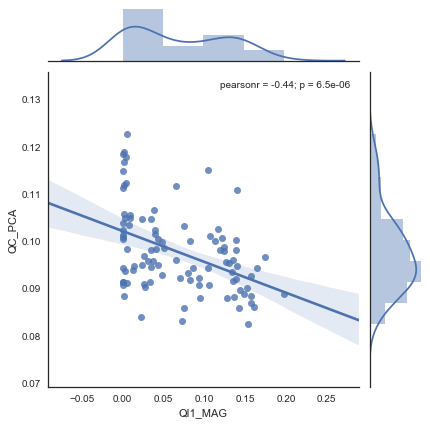

In [195]:
sns.jointplot(lemonx.QI1_MAG, lemonx.QC_PCA, kind ='reg')

In [196]:
for sub in lemonx.index:
    print sub, lemonx.loc[sub]['Age'], lemonx.loc[sub]['Gender'], lemonx.loc[sub]['SN'], np.round(lemonx.loc[sub]['QC_PCA'],5)*10, np.round(lemonx.loc[sub]['SNR_MAG'],5)*10

LEMON130 63 0 163.948 0.8241 -4.5954
LEMON144 21 1 142.71 0.8311 0.0537
LEMON166 66 0 195.05 0.839 0.99
LEMON118 25 1 126.3695 0.8578 -0.3256
LEMON163 72 0 89.5 0.858 -5.0751
LEMON180 23 0 106.5805 0.8589 -0.4609
LEMON203 24 0 132.2895 0.8685 -2.1609
LEMON153 25 1 140.6935 0.8792 -0.7629
LEMON215 28 0 132.901 0.8797 -2.8663
LEMON141 20 0 82.2655 0.8811 -4.7954
LEMON199 24 0 173.779 0.884 -2.8827
LEMON168 61 0 79.835 0.8843 -0.5136
LEMON179 21 0 66.2215 0.888 -3.7871
LEMON138 26 0 137.558 0.8883 -3.376
LEMON117 42 1 74.9145 0.895 -3.3542
LEMON224 24 0 109.4165 0.9011 -4.37
LEMON223 31 0 153.802 0.9024 2.9522
LEMON148 22 1 93.7015 0.9055 -3.1391
LEMON211 24 0 109.271 0.906 -4.8141
LEMON165 69 0 100.8485 0.9067 -6.2951
LEMON143 66 0 83.7005 0.9086 4.6767
LEMON142 20 1 88.2685 0.9113 -1.483
LEMON177 27 0 89.985 0.9129 -4.3746
LEMON162 71 0 213.0505 0.9131 2.3529
LEMON164 72 0 109.5815 0.9133 6.454
LEMON210 22 0 59.179 0.915 -3.3885
LEMON198 27 0 88.9495 0.9162 4.7477
LEMON213 26 0 152.064 

In [170]:
lemonx

,Age,Gender,Group,SNR_UNI,CNR_UNI,FBER_UNI,EFC_UNI,FWHM_UNI,QI1_UNI,SNR_MAG,CNR_MAG,FBER_MAG,EFC_MAG,FWHM_MAG,QI1_MAG,R_Caud,R_Puta,R_Pall,R_Amyg,R_Hipp,R_Accu,R_Thal,L_Caud,L_Puta,L_Pall,L_Amyg,L_Hipp,L_Accu,L_Thal,L_BG,R_BG,R_RN,R_SN,R_STN,L_RN,L_SN,L_STN,str_div3_motor,str_div3_limbic,str_div3_executive,MRS_ACC,MRS_THA,MRS_STR,GM,WM,CSF,Caud,Puta,Pall,Amyg,Hipp,Accu,Thal,SN,RN,STN,BG,BS,QC_PCA,Chi_PCA,Caud_Puta
LEMON130,63,0,Controls,2.044686,1.175850,-2.751205,NaN,3.49867,0.270245,-0.459542,0.069578,1.163768,0.422922,2.72293,0.153834,2.629,18.059,112.581,-33.021,-12.546,-17.852,-25.926,15.850,15.566,116.060,-31.003,-8.869,-16.131,-30.440,27.451,23.245,100.115,179.214,85.155,92.676,148.682,50.091,25.834,7.936,-3.114,NaN,NaN,NaN,-20.461,-26.845,-9.175,9.2395,16.8125,114.3205,-32.0120,-10.7075,-16.9915,-28.1830,163.9480,96.3955,67.6230,25.3480,109.322167,0.082406,0.115735,13.02600
LEMON144,21,1,Controls,2.072483,1.439771,-1.195303,NaN,3.39232,0.179717,0.005370,0.086769,0.855248,0.429906,2.95924,0.072755,4.821,-20.716,88.547,-36.714,-33.749,-41.510,-44.096,7.209,-22.298,83.156,-29.585,-42.021,-20.634,-47.604,3.509,3.077,43.057,156.537,83.898,36.603,128.883,90.494,-21.078,-24.495,-3.961,NaN,NaN,NaN,-30.900,-34.708,-15.945,6.0150,-21.5070,85.8515,-33.1495,-37.8850,-31.0720,-45.8500,142.7100,39.8300,87.1960,3.2930,89.912000,0.083113,0.091199,-7.74600
LEMON166,66,0,Controls,1.941098,1.159922,-5.238687,NaN,3.70888,0.234670,0.099004,0.097856,0.866081,0.500977,2.97692,0.022497,30.443,53.019,112.646,-20.962,-0.343,-46.278,-22.717,27.873,52.183,125.743,-4.076,-6.795,-5.834,-28.535,47.841,47.432,181.372,219.559,71.896,134.132,170.541,103.614,55.963,4.886,29.893,NaN,NaN,NaN,-15.584,-24.996,-9.964,29.1580,52.6010,119.1945,-12.5190,-3.5690,-26.0560,-25.6260,195.0500,157.7520,87.7550,47.6365,146.852333,0.083896,0.147862,40.87950
LEMON118,25,1,Controls,1.903693,1.408269,-3.544897,NaN,3.41464,0.217729,-0.032563,0.041150,0.997081,0.435970,2.98267,0.075298,-11.546,-18.645,93.078,-50.157,-45.673,-63.906,-42.067,-13.359,-36.835,100.995,-55.776,-40.898,-14.081,-46.780,-9.872,-2.347,67.466,127.012,30.535,56.085,125.727,31.841,-28.479,-22.776,-25.138,NaN,NaN,NaN,-41.530,-43.916,-41.635,-12.4525,-27.7400,97.0365,-52.9665,-43.2855,-38.9935,-44.4235,126.3695,61.7755,31.1880,-6.1095,73.111000,0.085780,0.083389,-20.09625
LEMON163,72,0,Controls,1.961894,1.010215,-7.009406,NaN,3.42862,0.213030,-0.507505,0.080836,1.385478,0.386734,2.73047,0.143056,37.810,51.472,83.069,-42.539,3.933,-19.449,-18.367,40.065,63.050,82.459,12.860,9.196,-3.396,-15.351,54.719,48.515,115.460,89.581,30.583,91.559,89.419,62.327,66.460,16.576,38.742,NaN,NaN,NaN,-12.271,-20.998,-5.743,38.9375,57.2610,82.7640,-14.8395,6.5645,-11.4225,-16.8590,89.5000,103.5095,46.4550,51.6170,79.821500,0.085798,0.086338,48.09925
LEMON180,23,0,Controls,1.887871,1.340408,-2.166764,NaN,3.79830,0.282969,-0.046085,0.123392,1.134054,0.464868,2.88913,0.161280,2.007,-3.572,91.579,-49.164,-18.747,-43.424,-32.960,12.337,-9.934,95.016,-39.657,-26.183,-19.222,-26.895,11.679,7.721,41.478,121.372,86.244,41.342,91.789,54.689,-2.540,-9.525,-1.797,NaN,NaN,NaN,-22.533,-31.107,-13.805,7.1720,-6.7530,93.2975,-44.4105,-22.4650,-31.3230,-29.9275,106.5805,41.4100,70.4665,9.7000,72.819000,0.085888,0.079011,0.20950
LEMON203,24,0,Controls,1.945837,1.360231,-2.019619,NaN,3.90310,0.239662,-0.216086,0.099190,1.200423,0.432391,2.89157,0.157278,15.685,3.195,81.399,-45.725,-34.412,-13.300,-37.579,10.245,2.195,100.754,-54.518,-39.050,-16.465,-39.927,14.138,17.549,108.274,145.699,91.116,93.904,118.880,83.876,21.310,-13.161,4.213,NaN,NaN,NaN,-30.662,-39.734,-21.906,12.9650,2.6950,91.0765,-50.1215,-36.7310,-14.8825,-38.7530,132.2895,101.0890,87.4960,15.8435,106.958167,0.086854,0.106006,7.83000
LEMON153,25,1,Controls,1.882633,1.353979,-2.649674,NaN,3.66289,0.220665,-0.076289,0.026246,0.990271,0.429452,3.08005,0.095292,6.720,-22.515,70.761,-37.762,-47.806,-57.487,-58.353,9.673,-24.326,70.977,-45.129,-46.145,-23.506,-63.254,1.373,-0.042,84.04